In [1]:
import torch
import torchvision
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F

from pprint import pprint
import numpy as np
import torchinfo
from matplotlib import pyplot as plt
import time
import cv2
from PIL import Image
import time
from tqdm import tqdm
import torchinfo 
from pprint import pprint

# this is same for all the code

# Dataset class implementation was done by Anshul EE20BTECH1104
# Residual block was written by Dhruv Srikanth EE20BTECH11014
# various functions like mse, mae, ssim were written by Dhruv Srikanth and Anshul Gupta
# Basic architecture of the model was taken from internet and then later modified by Utkarsh Doshi E20BTECH11052

https://github.com/AntixK/PyTorch-VAE/blob/master/models/vq_vae.py

In [2]:
import pytorch_wavelet

In [3]:
import pywt
from PIL import Image

In [4]:
channels_img = 3
batch_size = 64
data_dir = r'C:/Users/utkar/Desktop/ivp/FFHQ64x64/'
#data_dir_new = r'C:/Users/utkar/Desktop/ML/Dataset/Celeb_dataset/500_img'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((64, 64)),
    #transforms.Normalize(())
    ])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True
)

device = 'cuda' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
!nvidia-smi

Sat Apr 29 23:49:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.52       Driver Version: 528.52       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8    13W /  95W |   2059MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:

# # calculate the variance of the dataset
# variance = torch.zeros((channels_img, 64, 64))
# for images, _ in train_loader:
#     variance += np.var(images).mean(dim=0)
# variance /= len(train_loader)
# 
# print(f"Dataset variance: {variance}")
# 

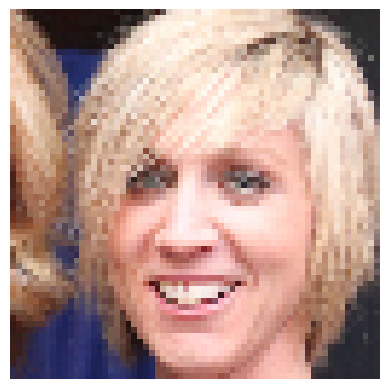

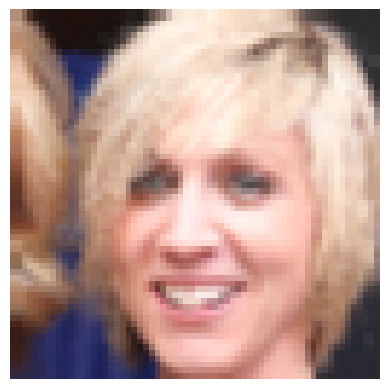

In [7]:
img = dataset[60000][0].permute(1, 2, 0)
plt.axis('off')
plt.imshow(img)
plt.show()

img_blur = torch.tensor(cv2.blur(np.array(img), (2, 2)))
plt.axis('off')
plt.imshow(img_blur)
plt.show()


In [8]:
# residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(ResidualBlock, self).__init__()
        self.ResBlock = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False)
        )
        
    def forward(self, x):
        return x + self.ResBlock(x)
    

# copied most the below snippet from github https://github.com/huggingface/pytorch-image-models

In [9]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        super(VectorQuantizer, self).__init__()
        self.K = num_embeddings
        self.D = embedding_dim
        self.beta = beta
        
        self.embedding = nn.Embedding(self.K, self.D)
        self.embedding.weight.data.uniform_(-1 / self.K, 1 / self.K)  # weight initializing
        
    def forward(self, latents):
        latents = latents.permute(0, 2, 3, 1).contiguous()  # taking dimension (channel) to right end
        latents_shape = latents.shape
        flat_latents = latents.view(-1, self.D)
        
        # computing L2 distance
        dist = torch.sum(flat_latents ** 2, dim=1, keepdim=True) + torch.sum(self.embedding.weight ** 2, dim=1) - \
               2 * torch.matmul(flat_latents, self.embedding.weight.t())  # [BHW x K]
            
        # Get the encoding that has the min distance
        encoding_inds = torch.argmin(dist, dim=1).unsqueeze(1)  # [BHW, 1]
        
        # Convert to one-hot encodings
        device = latents.device
        encoding_one_hot = torch.zeros(encoding_inds.size(0), self.K, device=device)
        encoding_one_hot.scatter_(1, encoding_inds, 1)  # [BHW x K]

        # Quantize the latents
        quantized_latents = torch.matmul(encoding_one_hot, self.embedding.weight)  # [BHW, D]
        quantized_latents = quantized_latents.view(latents_shape)  # [B x H x W x D]
        
        # Compute the VQ Losses
        commitment_loss = F.mse_loss(quantized_latents.detach(), latents)
        embedding_loss = F.mse_loss(quantized_latents, latents.detach())
        
        vq_loss = commitment_loss * self.beta + embedding_loss

        # Add the residue back to the latents
        quantized_latents = latents + (quantized_latents - latents).detach()

        return quantized_latents.permute(0, 3, 1, 2).contiguous(), vq_loss  # [B x D x H x W]

In [10]:
# VQ-VAE
class VQVAE(nn.Module):
    def __init__(self,
                 in_c,
                 embedding_dim,
                 num_embeddings,
                 hidden_dims=None,
                 beta=0.25,
                 img_size=64,
                 ):
        super(VQVAE, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.num_embedding = num_embeddings
        self.img_size = img_size
        self.beta = beta
        
        modules = []
        if hidden_dims is None:
            hidden_dims = [128, 256]
        
        for h_dim in hidden_dims:
            modules.append(nn.Sequential(
                nn.Conv2d(in_c, out_channels=h_dim, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(True),
            ))
            in_c = h_dim
            
        modules.append(
            nn.Sequential(
                nn.Conv2d(in_c, in_c, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            )
        )
        
        for _ in range(6):
            modules.append(ResidualBlock(in_c, in_c))   # see for relu
        modules.append(nn.LeakyReLU())
        
        modules.append(
            nn.Sequential(
                nn.Conv2d(in_c, embedding_dim, kernel_size=1, stride=1),
                nn.LeakyReLU()
            )
        )
        
        self.encoder = nn.Sequential(*modules)
        
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, self.beta)
        
        # Build Decoder
        modules = []
        modules.append(
            nn.Sequential(
                nn.Conv2d(embedding_dim, hidden_dims[-1], kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            )
        )
        
        
        for _ in range(6):
            modules.append(ResidualBlock(hidden_dims[-1], hidden_dims[-1]))
            
        modules.append(nn.LeakyReLU())
        hidden_dims.reverse()
        
        for i in range(len(hidden_dims)-1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i+1], kernel_size=4, stride=2, padding=1),
                    nn.LeakyReLU()
                )
            )
            
        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dims[-1], out_channels=3, kernel_size=4, stride=2, padding=1),
                nn.Tanh()
            )
        )
        
        self.decoder = nn.Sequential(*modules)
         
    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, z):
        z = self.decoder(z)
        return z
    
    def forward(self, x):
        encodings = self.encoder(x)
        #print(encodings.shape)
        quantized_vec, vq_loss = self.vq_layer(encodings)
        return [self.decoder(quantized_vec), x, vq_loss]
    
    def loss_f(self, *args, **kwargs):
        recons = args[0]
        inputs = args[1]
        vq_loss = args[2]
        
        recons_loss = F.mse_loss(recons, inputs)
        
        loss = recons_loss + vq_loss
        return loss, recons_loss, vq_loss
    
    def sample(self, num_samples, current_device):
        raise Warning('VQVAE sampler is not implemented.')

    def generate(self, x):
        return self.forward(x)[0]


In [11]:
# in_c, embedding_dim, num_embeddings, hidden_dims, beta=0.25, img_size=64,
vqvae = VQVAE(3, 128, 512).to(device)

In [12]:
# x = torch.rand((1, 3, 128, 128)).to('cuda')
# print(x.shape)
# encode_vec = vqvae.encoder(x)
# vqvae.vq_layer(encode_vec)[0].shape

In [13]:
pprint(torchinfo.summary(vqvae, (1, 3, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
VQVAE                                    [1, 3, 64, 64]            --
├─Sequential: 1-1                        [1, 128, 16, 16]          --
│    └─Sequential: 2-1                   [1, 128, 32, 32]          --
│    │    └─Conv2d: 3-1                  [1, 128, 32, 32]          6,272
│    │    └─LeakyReLU: 3-2               [1, 128, 32, 32]          --
│    └─Sequential: 2-2                   [1, 256, 16, 16]          --
│    │    └─Conv2d: 3-3                  [1, 256, 16, 16]          524,544
│    │    └─LeakyReLU: 3-4               [1, 256, 16, 16]          --
│    └─Sequential: 2-3                   [1, 256, 16, 16]          --
│    │    └─Conv2d: 3-5                  [1, 256, 16, 16]          590,080
│    │    └─LeakyReLU: 3-6               [1, 256, 16, 16]          --
│    └─ResidualBlock: 2-4                [1, 256, 16, 16]          --
│    │    └─Sequential: 3-7              [1, 256, 16, 16]          1,179

(tensor(0.0031), tensor(0.0377))
tensor(0.8086)


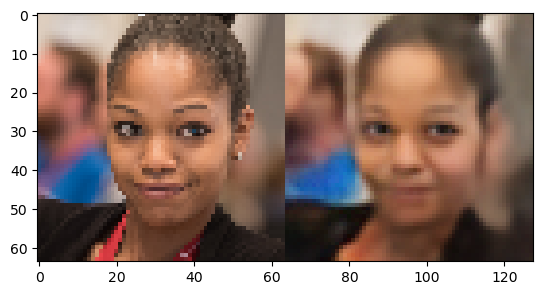

In [16]:
#import torch.optim.lr_scheduler as lr_scheduler

num_training_updates = 15000

# num_hiddens = 128
# num_residual_hiddens = 32
# num_residual_layers = 2
# 
# embedding_dim = 64
# num_embeddings = 512
# commitment_cost = 0.25
decay = 0.99

learning_rate = 1e-4
optimizer = optim.Adam(vqvae.parameters(), lr=learning_rate)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

criterion1 = nn.MSELoss()
criterion2 = nn.MSELoss()


from torchmetrics import MeanSquaredError
from torchmetrics import MeanAbsoluteError


def mse(img1, img2):
    target = img1
    preds = img2
    mean_squared_error = MeanSquaredError()
    mean_s = mean_squared_error(preds, target)
    mean_absolute_error = MeanAbsoluteError()
    mean_abs = mean_absolute_error(preds, target)
    return mean_s, mean_abs



from torchmetrics import StructuralSimilarityIndexMeasure
import torch
def ssim(img1, img2):
    target = img1
    preds = img2
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
    return ssim(preds, target)
    
def display_func():
    with torch.no_grad():
        n = 10001
        img = torch.unsqueeze(train_loader.dataset[n][0], 0).to('cuda')
        out = vqvae(img)[0]
        
        print(mse(img.cpu(), out.cpu()))
        print(ssim(img.cpu(), out.cpu()))
        pic = np.transpose(np.concatenate((img.cpu(), out.cpu()), 3)[0], (1, 2, 0))
        plt.imshow(pic)
        plt.show()

path = r"C:\Users\utkar\Desktop\ivp\models tried\day-3\vqvae_with_hlf_day3_epoch15.pt"
vqvae = torch.load(path)

display_func()

# Idea and implementation by Dhruv Srikanth a

In [ ]:


def dwt_batch(images, wavelet="haar", device="cuda"):
    with torch.no_grad():
        batch_size, channels, height, width = images.shape
        coeffs_list = []
        for i in range(batch_size):
            img = images[i].unsqueeze(0).to(device)
            coeffs = pywt.dwt2(img.cpu().numpy(), wavelet)
            cA, (cH, cV, cD) = coeffs
            cA = torch.from_numpy(cA).float().unsqueeze(0).to(device)
            cH = torch.from_numpy(cH).float().unsqueeze(0).to(device)
            cV = torch.from_numpy(cV).float().unsqueeze(0).to(device)
            cD = torch.from_numpy(cD).float().unsqueeze(0).to(device)
            coeffs_list.append((cA, cH, cV, cD))
        cA_batch = torch.cat([x[0] for x in coeffs_list], dim=0)
        cH_batch = torch.cat([x[1] for x in coeffs_list], dim=0)
        cV_batch = torch.cat([x[2] for x in coeffs_list], dim=0)
        cD_batch = torch.cat([x[3] for x in coeffs_list], dim=0)
    return cH_batch, cV_batch, cD_batch


        
display_func()

In [16]:


def train_vqvae(model, train_loader, optimizer, criterion1, criterion2, device, epochs=10):
    model.train()
    
    train_loss = []
    recon_loss = []
    vq_loss = []
    
    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_recon_loss = 0
        epoch_vq_loss = 0
        epoch_hlf_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (data, _) in enumerate(progress_bar):
            data = data.to(device)

            optimizer.zero_grad()

            outputs = model(data)
            
            input_hlf = dwt_batch(data)
            output_hlf = dwt_batch(outputs[0])
            
            hlf_loss = criterion2((output_hlf[0]+output_hlf[1]+output_hlf[2])/3 ,  (input_hlf[0]+input_hlf[1]+input_hlf[2])/3)
            sum_loss, recon_loss_batch, vq_loss_batch = model.loss_f(*outputs)
            
            loss = sum_loss + hlf_loss

            loss.backward()
            optimizer.step()

            epoch_hlf_loss += hlf_loss.item()
            epoch_train_loss += loss.item()
            epoch_recon_loss += recon_loss_batch.item()
            epoch_vq_loss += vq_loss_batch.item()

            progress_bar.set_postfix({
                "Train Loss": epoch_train_loss / (batch_idx + 1),
                "Recon Loss": epoch_recon_loss / (batch_idx + 1),
                "VQ Loss": epoch_vq_loss / (batch_idx + 1),
            })
            
        #scheduler.step()
        train_loss.append(epoch_train_loss / len(train_loader))
        recon_loss.append(epoch_recon_loss / len(train_loader))
        vq_loss.append(epoch_vq_loss / len(train_loader))

        print(f"Epoch {epoch+1}: Train Loss: {train_loss[-1]:.4f}, Recon Loss: {recon_loss[-1]:.4f}, VQ Loss: {vq_loss[-1]:.4f}")
        display_func()
        if epoch % 5 == 0:
            PATH = r'C:/Users/utkar/Desktop/ivp/models tried/day-3/vqvae_with_hlf_day3_epoch' + str(epoch) + '.pt'
            torch.save(vqvae, PATH)
    return train_loss, recon_loss, vq_loss


Epoch 1/20: 100%|████████████████████| 969/969 [10:14<00:00,  1.58it/s, Train Loss=64, Recon Loss=0.0484, VQ Loss=63.9]

Epoch 1: Train Loss: 63.9844, Recon Loss: 0.0484, VQ Loss: 63.9337


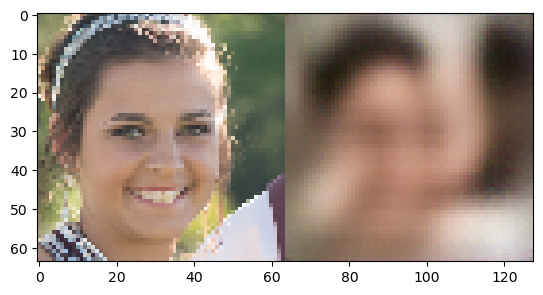

Epoch 2/20: 100%|██████████████| 969/969 [04:04<00:00,  3.96it/s, Train Loss=0.0914, Recon Loss=0.0191, VQ Loss=0.0703]

Epoch 2: Train Loss: 0.0914, Recon Loss: 0.0191, VQ Loss: 0.0703


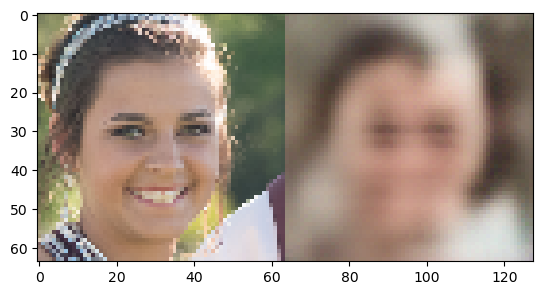

Epoch 3/20: 100%|██████████████| 969/969 [04:04<00:00,  3.97it/s, Train Loss=0.0294, Recon Loss=0.0163, VQ Loss=0.0113]

Epoch 3: Train Loss: 0.0294, Recon Loss: 0.0163, VQ Loss: 0.0113


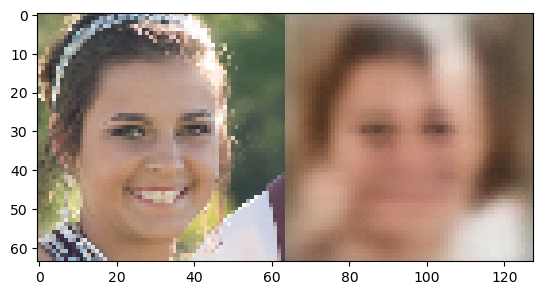

Epoch 4/20: 100%|█████████████| 969/969 [04:06<00:00,  3.93it/s, Train Loss=0.0224, Recon Loss=0.0137, VQ Loss=0.00674]

Epoch 4: Train Loss: 0.0224, Recon Loss: 0.0137, VQ Loss: 0.0067


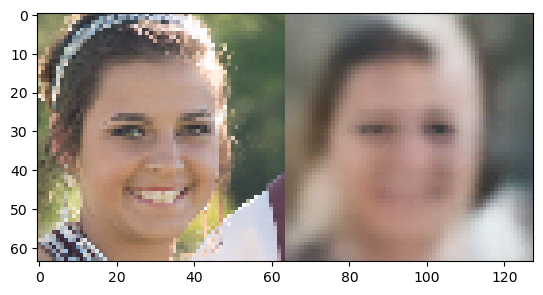

Epoch 5/20: 100%|█████████████| 969/969 [04:03<00:00,  3.98it/s, Train Loss=0.0188, Recon Loss=0.0119, VQ Loss=0.00502]

Epoch 5: Train Loss: 0.0188, Recon Loss: 0.0119, VQ Loss: 0.0050


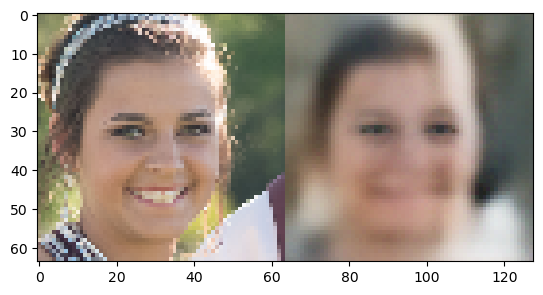

Epoch 6/20: 100%|█████████████| 969/969 [04:03<00:00,  3.97it/s, Train Loss=0.0167, Recon Loss=0.0107, VQ Loss=0.00429]

Epoch 6: Train Loss: 0.0167, Recon Loss: 0.0107, VQ Loss: 0.0043


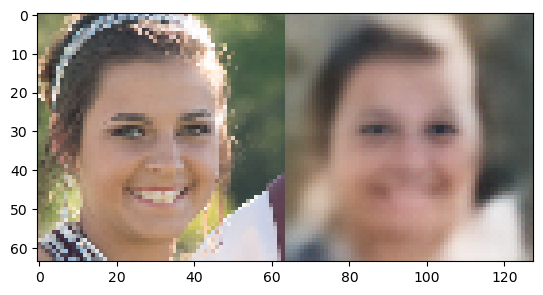

Epoch 7/20: 100%|████████████| 969/969 [04:04<00:00,  3.96it/s, Train Loss=0.0148, Recon Loss=0.00945, VQ Loss=0.00365]

Epoch 7: Train Loss: 0.0148, Recon Loss: 0.0095, VQ Loss: 0.0036


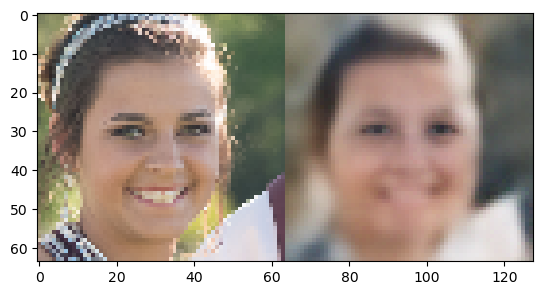

Epoch 8/20: 100%|████████████| 969/969 [04:05<00:00,  3.95it/s, Train Loss=0.0134, Recon Loss=0.00863, VQ Loss=0.00309]

Epoch 8: Train Loss: 0.0134, Recon Loss: 0.0086, VQ Loss: 0.0031


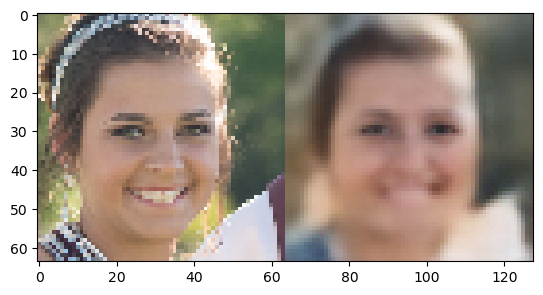

Epoch 9/20: 100%|████████████| 969/969 [04:04<00:00,  3.96it/s, Train Loss=0.0123, Recon Loss=0.00804, VQ Loss=0.00266]

Epoch 9: Train Loss: 0.0123, Recon Loss: 0.0080, VQ Loss: 0.0027


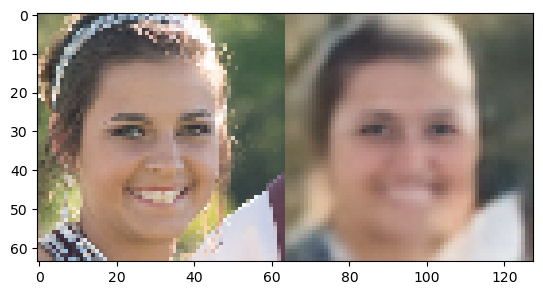

Epoch 10/20: 100%|███████████| 969/969 [04:05<00:00,  3.95it/s, Train Loss=0.0113, Recon Loss=0.00754, VQ Loss=0.00222]

Epoch 10: Train Loss: 0.0113, Recon Loss: 0.0075, VQ Loss: 0.0022


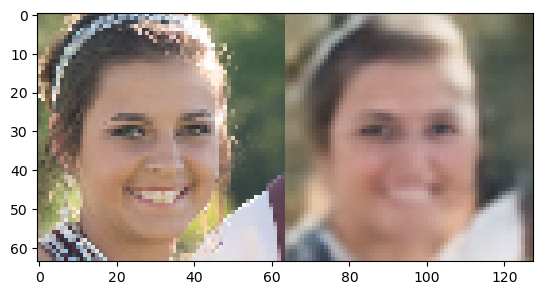

Epoch 11/20: 100%|███████████| 969/969 [04:05<00:00,  3.95it/s, Train Loss=0.0107, Recon Loss=0.00715, VQ Loss=0.00202]

Epoch 11: Train Loss: 0.0107, Recon Loss: 0.0072, VQ Loss: 0.0020


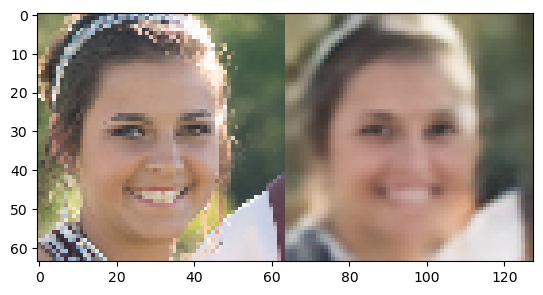

Epoch 12/20: 100%|███████████| 969/969 [04:04<00:00,  3.97it/s, Train Loss=0.0104, Recon Loss=0.00675, VQ Loss=0.00215]

Epoch 12: Train Loss: 0.0104, Recon Loss: 0.0068, VQ Loss: 0.0021


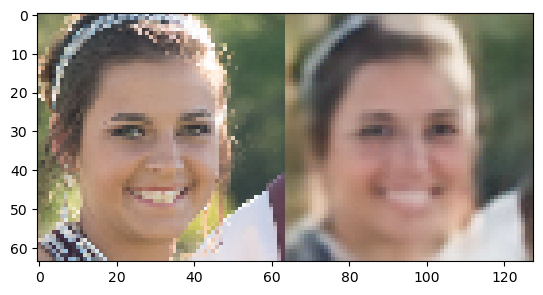

Epoch 13/20: 100%|███████████| 969/969 [04:04<00:00,  3.96it/s, Train Loss=0.0105, Recon Loss=0.00632, VQ Loss=0.00279]

Epoch 13: Train Loss: 0.0105, Recon Loss: 0.0063, VQ Loss: 0.0028


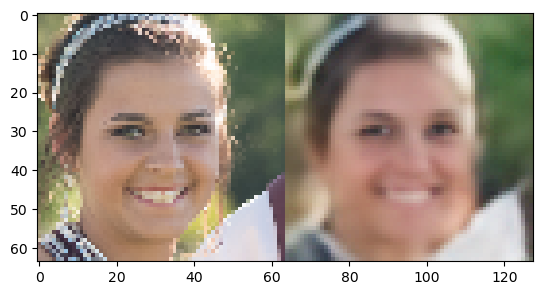

Epoch 14/20: 100%|███████████| 969/969 [04:04<00:00,  3.96it/s, Train Loss=0.0136, Recon Loss=0.00766, VQ Loss=0.00444]

Epoch 14: Train Loss: 0.0136, Recon Loss: 0.0077, VQ Loss: 0.0044


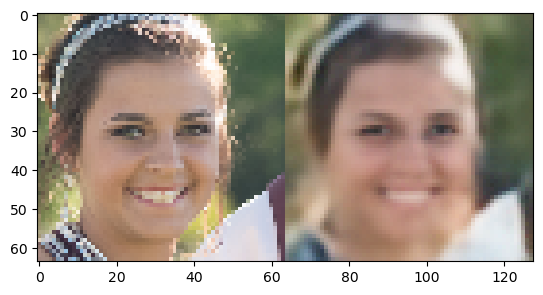

Epoch 15/20: 100%|███████████| 969/969 [04:02<00:00,  4.00it/s, Train Loss=0.0116, Recon Loss=0.00596, VQ Loss=0.00423]

Epoch 15: Train Loss: 0.0116, Recon Loss: 0.0060, VQ Loss: 0.0042


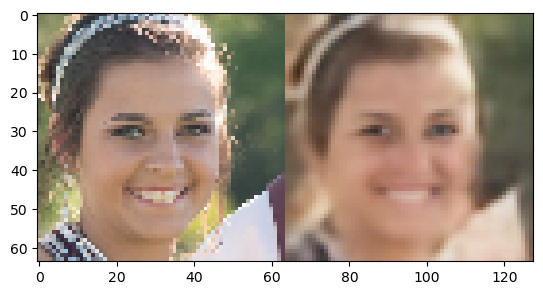

Epoch 16/20: 100%|████████████| 969/969 [03:59<00:00,  4.05it/s, Train Loss=0.0121, Recon Loss=0.0057, VQ Loss=0.00506]

Epoch 16: Train Loss: 0.0121, Recon Loss: 0.0057, VQ Loss: 0.0051


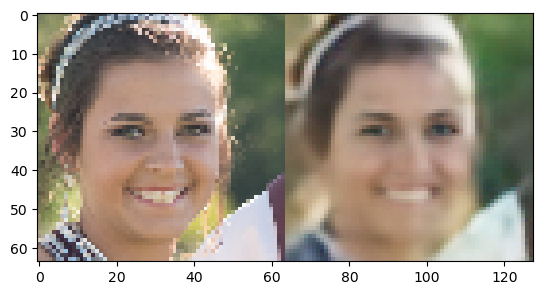

Epoch 17/20: 100%|███████████| 969/969 [04:04<00:00,  3.96it/s, Train Loss=0.0124, Recon Loss=0.00559, VQ Loss=0.00551]

Epoch 17: Train Loss: 0.0124, Recon Loss: 0.0056, VQ Loss: 0.0055


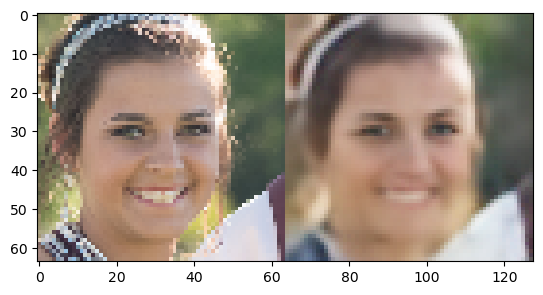

Epoch 18/20: 100%|████████████| 969/969 [04:04<00:00,  3.96it/s, Train Loss=0.0211, Recon Loss=0.00787, VQ Loss=0.0118]

Epoch 18: Train Loss: 0.0211, Recon Loss: 0.0079, VQ Loss: 0.0118


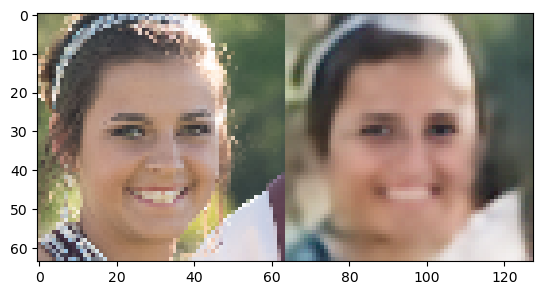

Epoch 19/20: 100%|███████████| 969/969 [04:04<00:00,  3.96it/s, Train Loss=0.0123, Recon Loss=0.00601, VQ Loss=0.00491]

Epoch 19: Train Loss: 0.0123, Recon Loss: 0.0060, VQ Loss: 0.0049


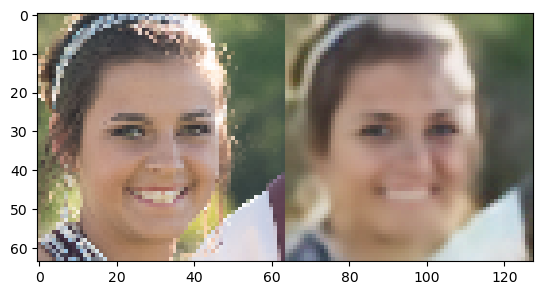

Epoch 20/20: 100%|████████████| 969/969 [04:04<00:00,  3.96it/s, Train Loss=0.012, Recon Loss=0.00551, VQ Loss=0.00519]

Epoch 20: Train Loss: 0.0120, Recon Loss: 0.0055, VQ Loss: 0.0052


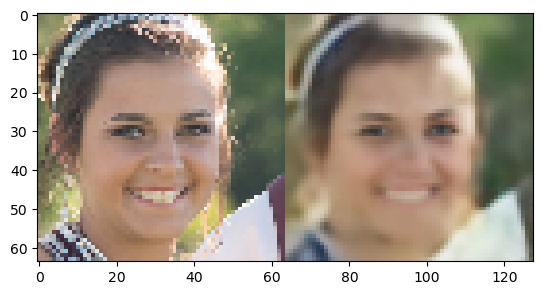

([63.98438306855205,
  0.091417807962657,
  0.029419836243162828,
  0.022354438201254243,
  0.018782119794342172,
  0.016739387126683696,
  0.014800585518034618,
  0.013370939742839127,
  0.012302319854651689,
  0.011317322365132278,
  0.01069162766207913,
  0.010373081811064598,
  0.010534029662555278,
  0.013575006644476986,
  0.011580485126851328,
  0.012118269710525702,
  0.012442278858347266,
  0.021145849580942847,
  0.012290542612719215,
  0.012028260890805807],
 [0.04838248056247138,
  0.019133518106843297,
  0.016264343115244488,
  0.013749734124685834,
  0.01194048480114393,
  0.010686678183337114,
  0.009450800872577972,
  0.00863043234180909,
  0.008043098284587095,
  0.007536594215799719,
  0.007153736462507116,
  0.006753327519132134,
  0.006320667279148004,
  0.007659292917302642,
  0.005957088603323827,
  0.005700659108712454,
  0.0055894942260256,
  0.007871551034535724,
  0.0060144366261090845,
  0.005506432028939049],
 [63.93374652144263,
  0.07031735037410222,
  0.0

In [17]:
train_vqvae(vqvae, train_loader, optimizer, criterion1, criterion2, device, epochs=20) 